Let's get to the point.
I'm refactoring old code to fit into the old models that I made
The problem is the preprocessing
And as always my crutch on AI has lead me astray
Regardless, I think I can get through this?

This notebook was written based on these resources:
https://www.kaggle.com/code/someadityamandal/bitcoin-time-series-forecasting/notebook
https://github.com/dataquestio/project-walkthroughs/tree/master/bitcoin_price
https://www.geeksforgeeks.org/time-series-forecasting-using-tensorflow/

Special thank you to David for, as always, having the best resources.

In [ ]:
# Let's try all that preprocessing again.
import numpy as np
import pandas as pd
import keras.layers as layers
import keras.models as models

import datetime, pytz
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# import os
# <!-- print(os.listdir('./data')) -->

In [27]:
# Okay so for some reasons those imports were taking WAY too long.

import yfinance as yf
import os

btc_ticker = yf.Ticker('BTC-USD')

if os.path.exists('btc.csv'):
    btc = pd.read_csv('btc.csv', index_col=0)
else:
    btc=btc_ticker.history(perid='max')
    btc.to_csv('btc.csv')

print(btc.head())
btc.info()

                                 Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  Dividends  Stock Splits  
Date                                                          
2014-09-17 00:00:00+00:00  21056800        0.0           0.0  
2014-09-18 00:00:00+00:00  34483200        0.0           0.0  
2014-09-19 00:00:00+00:00  37919700        0.0           0.0  
2014-09-20 00:00:00+00:00  36863600        0.0           0.0  
2014-09-21 00:00:00+00:00  26580100        0.0           0.0  
<class 'pandas.core

In [28]:
btc.index = pd.to_datetime(btc.index)
btc
btc.drop(columns=["Dividends", "Stock Splits"], inplace=True)
btc.columns = [c.lower() for c in btc.columns]
print(btc.head())
btc.info()

                                 open        high         low       close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             volume  
Date                                 
2014-09-17 00:00:00+00:00  21056800  
2014-09-18 00:00:00+00:00  34483200  
2014-09-19 00:00:00+00:00  37919700  
2014-09-20 00:00:00+00:00  36863600  
2014-09-21 00:00:00+00:00  26580100  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3713 entries, 2014-09-17 00:00:00+00:00 to 2024-11-16 00:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---

Not going to lie
I'm ashamed I didn't do that print earlier.
Regardless, easy bug to fix.

In [29]:
btc['tomorrow'] = btc['close'].shift(-1)
btc['target']  = (btc['tomorrow'] > btc['close']).astype(int)
btc.dropna(inplace=True)

split_date = "2024-05-05"
data_train = btc.loc[btc.index <= split_date].copy()
data_test = btc.loc[btc.index > split_date].copy()

In [31]:
sc = MinMaxScaler()
train_scaled = sc.fit_transform(data_train[['close']])
test_scaled = sc.transform(data_test[['close']])

X_train = train_scaled[:-1]
y_train = train_scaled[1:]

X_test = test_scaled[:-1]
y_test = test_scaled[1:]

X_train = np.reshape(X_train, (len(X_train), 1, 1))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

In [40]:
# please, please, please work
model1 = models.Sequential()

model1.add(layers.LSTM(128, activation='relu', input_shape=(1, 1)))
model1.add(layers.Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

model2 = models.Sequential()

# This one's more promising than the other's I've seen
model2.add(layers.LSTM(100, return_sequences=True))
model2.add(layers.LSTM(100, return_sequences=True))
model2.add(layers.LSTM(50))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1, activation= 'linear'))
# Interesting that this one does two different activation functions
# Suppose that makes sense though

# Ok last one is that weird amalgamation I did last time.
# Copy and pasting isn't cheating when it's your own code
model3 = models.Sequential()

model3.add(layers.LSTM(128, activation='relu', input_shape=(1, 1)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
71/71 - 3s - 39ms/step - loss: 0.0612
Epoch 2/100
71/71 - 0s - 6ms/step - loss: 0.0252
Epoch 3/100
71/71 - 0s - 4ms/step - loss: 0.0092
Epoch 4/100
71/71 - 0s - 3ms/step - loss: 0.0013
Epoch 5/100
71/71 - 0s - 3ms/step - loss: 3.2066e-04
Epoch 6/100
71/71 - 1s - 7ms/step - loss: 2.8722e-04
Epoch 7/100
71/71 - 0s - 6ms/step - loss: 2.8043e-04
Epoch 8/100
71/71 - 0s - 6ms/step - loss: 2.7517e-04
Epoch 9/100
71/71 - 0s - 6ms/step - loss: 2.6835e-04
Epoch 10/100
71/71 - 0s - 5ms/step - loss: 2.6194e-04
Epoch 11/100
71/71 - 0s - 5ms/step - loss: 2.5548e-04
Epoch 12/100
71/71 - 1s - 7ms/step - loss: 2.4964e-04
Epoch 13/100
71/71 - 0s - 7ms/step - loss: 2.4211e-04
Epoch 14/100
71/71 - 0s - 5ms/step - loss: 2.3955e-04
Epoch 15/100
71/71 - 0s - 4ms/step - loss: 2.2939e-04
Epoch 16/100
71/71 - 0s - 4ms/step - loss: 2.2197e-04
Epoch 17/100
71/71 - 0s - 5ms/step - loss: 2.1554e-04
Epoch 18/100
71/71 - 0s - 4ms/step - loss: 2.0820e-04
Epoch 19/100
71/71 - 0s - 5ms/step - loss: 2.0282e-0

HOLY HECKING CHRISTMAS CRACKERS IT'S WORKING
A bit faster than it was before though. So that's a wee bit concerning
Like. Really concerning actually
    Ok it's still going fast but I think it's slightly slower now?
    Ah, the second model is definitely taking some time.
    Oh heck I forgot about the soup
    Soup still needs some more time

In [41]:
model1.summary()
model2.summary()
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,075 (781.55 KB)

 Trainable params: 66,691 (260.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,384 (521.04 KB)

In [42]:
predictions1 = model1.predict(X_test)
predictions2 = model2.predict(X_test)
predictions3 = model3.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


I /really/ feel like those should have taken longer
I'm getting worried

In [43]:
predicted_prices1 = sc.inverse_transform(predictions1)
predicted_prices2 = sc.inverse_transform(predictions2)
predicted_prices3 = sc.inverse_transform(predictions3)

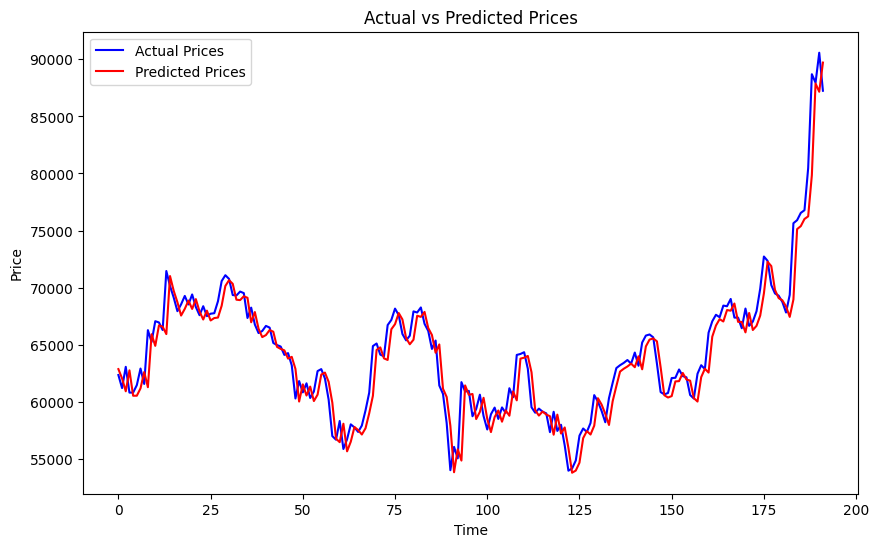

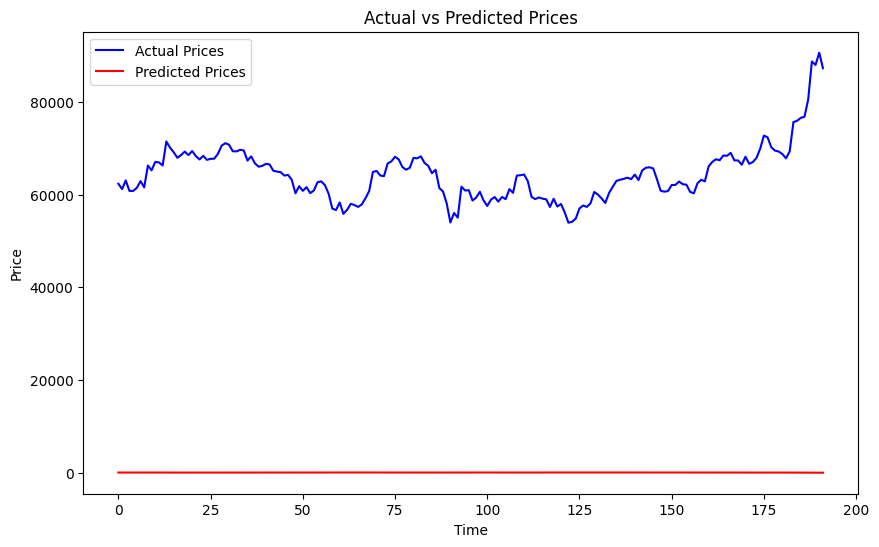

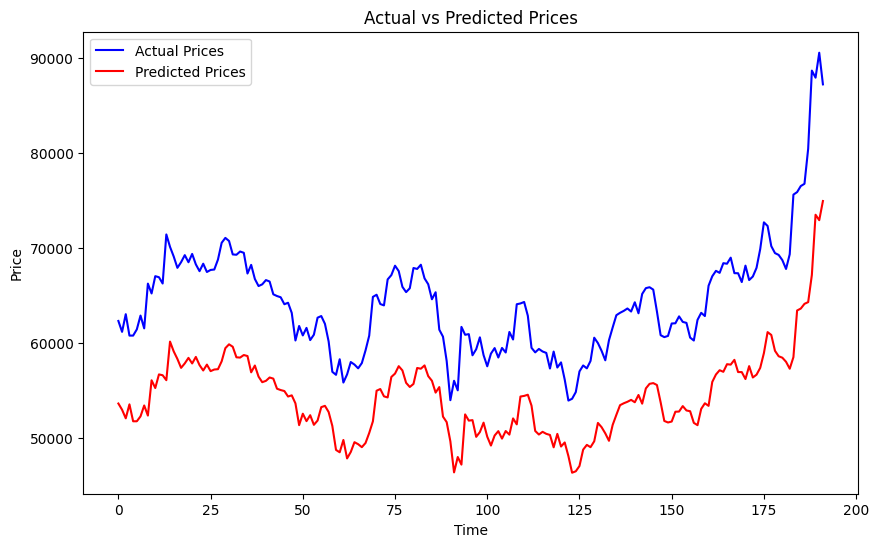

In [44]:
# Is there an easier way to do this? Sure! Am I going to do it? No!
import matplotlib.pyplot as plt

# Rescale actual prices back to original scale
actual_prices = sc.inverse_transform(y_test)

# Plot predictions vs. actual prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predicted_prices1, label="Predicted Prices", color='red')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predicted_prices2, label="Predicted Prices", color='red')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label="Actual Prices", color='blue')
plt.plot(predicted_prices3, label="Predicted Prices", color='red')
plt.title("Actual vs Predicted Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
# That is almost definitely wrong

In [45]:
# We'll go ahead and set up some play while we wait for those models to train
print(f"Shape of the data: {btc.shape}")
print(f"How many are null? {btc.isnull().sum()}")
print(f"Description of data: {btc.describe()}")
print(f"And a little bit of data: {btc.head()}")

Shape of the data: (3712, 7)
How many are null? open        0
high        0
low         0
close       0
volume      0
tomorrow    0
target      0
dtype: int64
Description of data:                open          high           low         close        volume  \
count   3712.000000   3712.000000   3712.000000   3712.000000  3.712000e+03   
mean   18583.789688  19005.207769  18143.122326  18605.985091  1.798011e+10   
std    20437.413163  20896.156197  19960.619884  20464.453455  1.953657e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%     1186.287537   1206.827515   1172.422485   1187.855011  3.361940e+08   
50%     9263.631836   9419.822266   9108.638672   9269.374512  1.428786e+10   
75%    29911.524902  30443.790527  29378.837891  29937.283203  2.897808e+10   
max    90574.882812  93434.351562  86682.812500  90584.164062  3.509679e+11   

           tomorrow       target  
count   3712.000000  3712.000000  
mean   18630.540880     0.528825  
std

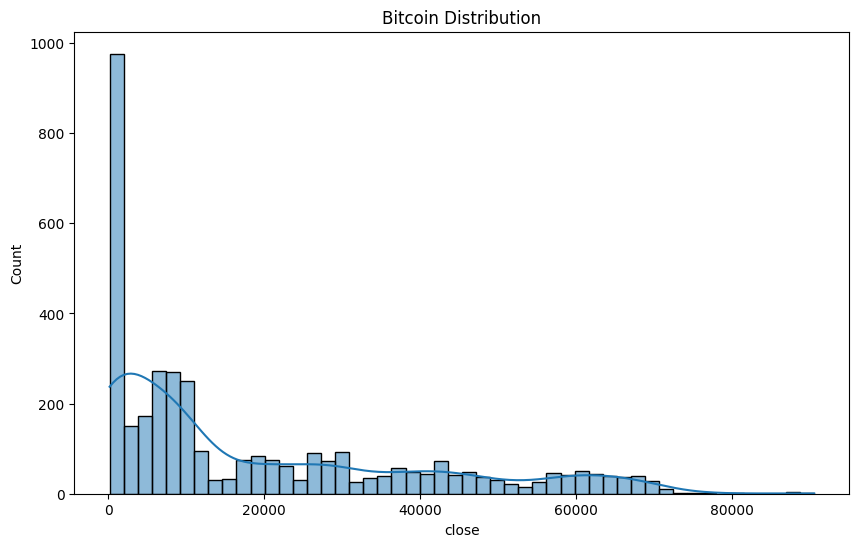

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(btc['close'], bins=50, kde=True)
plt.title('Bitcoin Distribution')
plt.show()

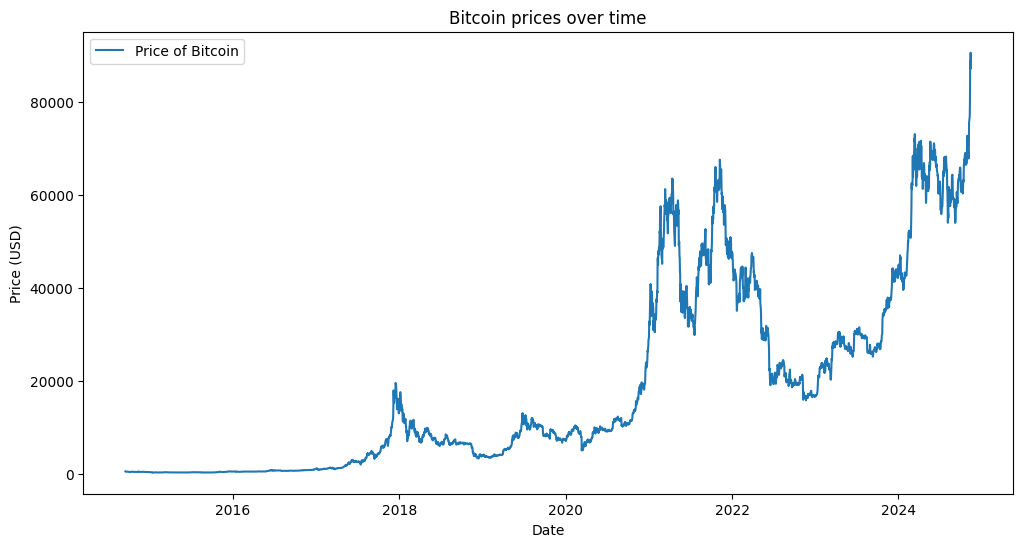

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(btc['close'], label='Price of Bitcoin')
plt.title('Bitcoin prices over time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

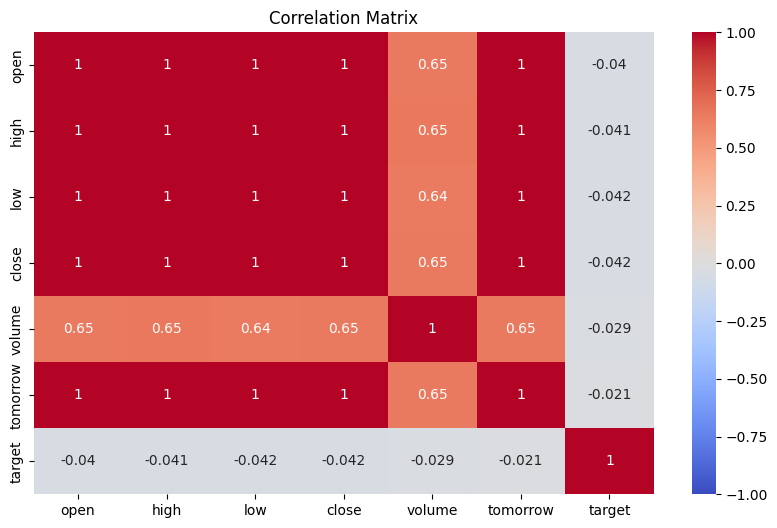

In [48]:
# Oh cool, I found some info on correlation matrixes visualization
corr_matrix = btc.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Oooooh seasonality too